In [1]:
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import librosa
from dataset import ALCDataset

%matplotlib inline

In [2]:
SR = 16000

### Load data

In [3]:
alc_dataset = ALCDataset('/Users/mazeyu/Desktop/CMU/20fall/18797/project/code/data')
data_train, label_train = alc_dataset.load_data('train', percentage=1.0, num_threads=4)
data_dev1, label_dev1 = alc_dataset.load_data('d1', percentage=1.0, num_threads=4)
data_dev2, label_dev2 = alc_dataset.load_data('d2', percentage=1.0, num_threads=4)
data_test, label_test = alc_dataset.load_data('test', percentage=1.0, num_threads=4)

In [4]:
assert len(data_train) == len(label_train)
assert len(data_dev1) == len(label_dev1)
assert len(data_dev2) == len(label_dev2)
assert len(data_test) == len(label_test)

print('#train: {}'.format(len(data_train)))
print('#dev1: {}'.format(len(data_dev1)))
print('#dev2: {}'.format(len(data_dev2)))
print('#test: {}'.format(len(data_test)))

#train: 5400
#dev1: 3960
#dev2: 1500
#test: 3000


### Feature extraction

In [26]:
class ALCFeature:
    def __init__(self, sr):
        self.sr = sr
        
    def delete_silence(self, audio, top_db=20):
        result = []
        intervals = librosa.effects.split(audio, top_db=top_db, frame_length=2048, hop_length=512)
        for interval in intervals:
            result.append(audio[interval[0]: interval[1]])
        result = np.concatenate(result)
        return result
        
    def get_mfcc(self, data, label, n_mfcc=20, wsize=0.1, concat=5, scale=True):
        x_mfcc = []
        y_mfcc = []
        record_mfcc = []
        wsize = int(wsize * self.sr)
        for i in tqdm(range(len(data)), ncols=100, ascii=True, desc='MFCC feature'):
            audio = self.delete_silence(data[i])
            x = librosa.feature.mfcc(audio, sr=self.sr, n_mfcc=n_mfcc, n_fft=2048, hop_length=512, win_length=wsize, window='hann')
            if scale:
                x = x - np.min(x, axis=1, keepdims=True)
            for j in range(x.shape[1] // concat):
                slice_ = x[:, j * concat: (j + 1) * concat]
                x_mfcc.append(slice_.flatten())
                y_mfcc.append(label[i])
                record_mfcc.append(i)
        x_mfcc = np.stack(x_mfcc)
        y_mfcc = np.array(y_mfcc)
        record_mfcc = np.array(record_mfcc)
        return x_mfcc, y_mfcc, record_mfcc
    
    def pncc(self, data, label):
        pass
    
    def get_cqt(self, data, label):
        pass

In [27]:
alc_feature = ALCFeature(SR)

x_train, y_train, record_train = alc_feature.get_mfcc(data_train, label_train)
x_dev1, y_dev1, record_dev1 = alc_feature.get_mfcc(data_dev1, label_dev1)
x_dev2, y_dev2, record_dev2 = alc_feature.get_mfcc(data_dev2, label_dev2)
x_test, y_test, record_test = alc_feature.get_mfcc(data_test, label_test)

MFCC feature: 100%|############################################| 3000/3000 [00:24<00:00, 120.47it/s]


In [28]:
pca = sklearn.decomposition.PCA(n_components=50)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_dev1 = pca.transform(x_dev1)
x_dev2 = pca.transform(x_dev2)
x_test = pca.transform(x_test)

### Classification model

In [29]:
class ALCModel:
    def __init__(self, method, verbose=None):
        if method == 'lr':
            if verbose is None:
                verbose = 0
            self.clf = LogisticRegression(verbose=verbose)
        elif method == 'svm':
            if verbose is None:
                verbose = False
            self.clf = SVC(C=1.0, kernel='rbf', verbose=verbose)
        elif method == 'forest':
            if verbose is None:
                verbose = 0
            self.clf = RandomForestClassifier(n_estimators=100, verbose=verbose)
        elif method == 'adaboost':
            self.clf = AdaBoostClassifier(n_estimators=100)
        else:
            pass
        
    def fit(self, x, y):
        self.clf.fit(x, y)
    
    def predict(self, x, record):
        prediction = []
        probability = []
        raw_pred = self.clf.predict(x)
        for i in range(record[-1] + 1):
            this_pred = raw_pred[record == i]
            if len(this_pred) == 0:
                this_prob = np.random.uniform(low=0.0, high=1.0)
                this_pred = np.random.choice([0, 1])              
            else:
                this_prob = np.mean(this_pred)
                this_pred = np.argmax(np.bincount(this_pred))
            prediction.append(this_pred)
            probability.append(this_prob)
        prediction = np.array(prediction)
        probability = np.array(probability)
        return prediction, probability
    
    def evaluate(self, x, record, label, roc=False):
        pred, prob = self.predict(x, record)
        acc = np.mean(pred == label)
        report = sklearn.metrics.classification_report(label, pred)
        if roc:
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(label, prob)
            plt.figure()
            plt.plot(fpr, tpr)
            plt.title('ROC Curve')
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.show()
        return acc, report

In [ ]:
model = ALCModel('svm')
model.fit(x_train, y_train)
acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
print(report)

In [ ]:
model = ALCModel('lr')
model.fit(x_train, y_train)
acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
print(report)

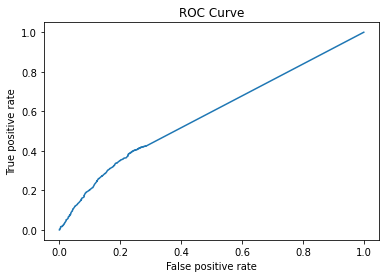

acc:  0.501
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1500
           1       0.71      0.00      0.01      1500

    accuracy                           0.50      3000
   macro avg       0.61      0.50      0.34      3000
weighted avg       0.61      0.50      0.34      3000



In [31]:
model = ALCModel('forest')
model.fit(x_train, y_train)
acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
print(report)

In [ ]:
model = ALCModel('adaboost')
model.fit(x_train, y_train)
model.fit(x_train, y_train)
acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
print(report)